The notebook attempts to address the Multi-emotion dectection problem from the link https://github.com/savan77/EmotionDetectionBERT/

In [5]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification
from collections import Counter
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Bidirectional,GlobalAveragePooling1D, Dropout
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import BinaryAccuracy


#!pip install tensorflow_text
import tensorflow_hub as hub




In [6]:

#drive.mount('/content/drive/')
#os.chdir('/content/drive/My Drive/BERT/Multi_emotion')

In [7]:
!nvidia-smi

Tue Apr 30 12:21:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              33W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_test.csv')
df_val = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_valid.csv')


In [9]:
df_train.shape, df_val.shape, df_test.shape

((1493, 14), (1493, 14), (374, 14))

In [10]:
df_train = df_train.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()

In [11]:
df_train.shape, df_val.shape, df_test.shape

((1493, 14), (165, 14), (374, 14))

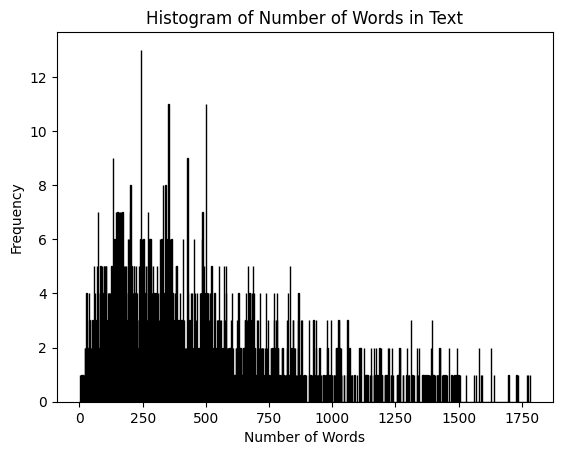

In [12]:
df_total = pd.concat([df_train, df_test, df_val], axis = 0)

df_total['text_length'] = df_total['text'].apply(lambda x: len(x.split()))

# Vẽ biểu đồ histogram
plt.hist(df_total['text_length'], bins=range(0, max(df_total['text_length']) + 1, 1), color='blue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()


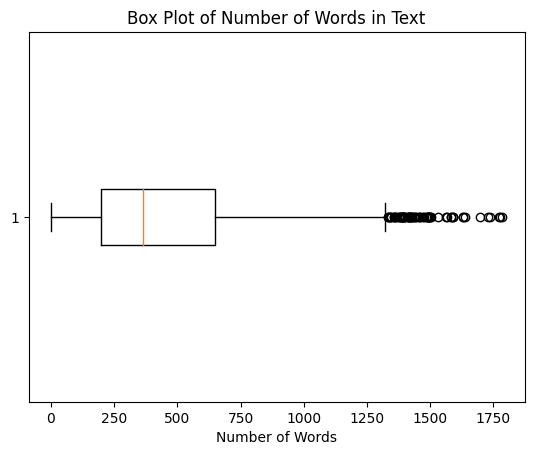

In [13]:
plt.boxplot(df_total['text_length'], vert=False)
plt.xlabel('Number of Words')
plt.title('Box Plot of Number of Words in Text')
plt.show()

Most of sentences has less than 700 words.

# Logistic regression with tf-idf

In [14]:
vectorizer = TfidfVectorizer(stop_words='english', min_df = 10)
X_total = vectorizer.fit_transform(df_total['text'])
X_total.shape

(2032, 5476)

In [15]:
X_train = X_total[:df_train.shape[0],:]
y_train = df_train.iloc[:, 2:]
X_train.shape

(1493, 5476)

In [16]:
X_val = X_total[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]
y_val = df_val.iloc[:, 2:]
X_val.shape

(165, 5476)

In [17]:
X_test =  X_total[df_train.shape[0] + df_val.shape[0]:, :]
y_test = df_test.iloc[:, 2:]
X_test.shape

(374, 5476)

In [18]:
logistic_model = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)

Result on train

In [19]:
y_predict = logistic_model.predict(X_train)
print(classification_report(y_train, y_predict, target_names=y_test.columns.to_list()))


              precision    recall  f1-score   support

       anger       0.93      0.66      0.77       544
anticipation       0.87      0.87      0.87       751
     disgust       0.91      0.81      0.86       678
        fear       0.90      0.79      0.84       678
         joy       0.67      0.01      0.02       185
        love       0.00      0.00      0.00       138
    optimism       0.98      0.43      0.60       490
   pessimism       0.89      0.76      0.82       646
     sadness       0.96      0.32      0.48       414
    surprise       1.00      0.01      0.02       162
       trust       0.89      0.03      0.06       251
     neutral       1.00      0.02      0.03       169

   micro avg       0.91      0.58      0.71      5106
   macro avg       0.83      0.39      0.45      5106
weighted avg       0.88      0.58      0.64      5106
 samples avg       0.70      0.50      0.56      5106



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Result on test

In [20]:
y_predict = logistic_model.predict(X_test)
print(classification_report(y_test, y_predict, target_names=y_test.columns.to_list()))



              precision    recall  f1-score   support

       anger       0.34      0.22      0.27       121
anticipation       0.60      0.52      0.56       218
     disgust       0.39      0.35      0.37       156
        fear       0.50      0.37      0.42       195
         joy       0.00      0.00      0.00        70
        love       0.00      0.00      0.00        30
    optimism       0.20      0.08      0.12        97
   pessimism       0.33      0.31      0.32       120
     sadness       0.46      0.08      0.14       136
    surprise       0.00      0.00      0.00        49
       trust       0.50      0.02      0.03        60
     neutral       1.00      0.03      0.05        38

   micro avg       0.44      0.25      0.32      1290
   macro avg       0.36      0.16      0.19      1290
weighted avg       0.40      0.25      0.28      1290
 samples avg       0.32      0.24      0.24      1290



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The result on test is quiet bad. Let's to try others approach.

# Using LSTM



In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_total['text'].values)
maxlen = 700
train_sequences = tokenizer.texts_to_sequences(df_train['text'])
X_train_tok = pad_sequences(train_sequences, maxlen=maxlen)

val_sequences = tokenizer.texts_to_sequences(df_val['text'])
X_val_tok = pad_sequences(val_sequences, maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1
vocab_size

38441

In [22]:
drop_out = 0.4
input_dim = vocab_size
output_dim = 70
input_length = maxlen
optimizer = Adam(learning_rate=0.001)
metrics = [BinaryAccuracy(threshold=0.3)]
#Build model

model = Sequential()
#Embedding Layer
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length = input_length))
#LSTM Layer
model.add(Bidirectional(LSTM(units=output_dim, dropout= drop_out, return_sequences=True)))

model.add(Bidirectional(LSTM(units=output_dim,return_sequences=True)))

model.add(GlobalAveragePooling1D())
#Dense Layer
model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(50, activation = 'relu'))
model.add(Dense(12, activation = 'sigmoid'))

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)


In [23]:
model.fit(X_train_tok, y_train, epochs=50, batch_size=32,
          validation_data=(X_val_tok, y_val))


Epoch 1/50
47/47 [==============================] - 24s 292ms/step - loss: 0.5726 - binary_accuracy: 0.5609 - val_loss: 0.5356 - val_binary_accuracy: 0.6520
Epoch 2/50
47/47 [==============================] - 11s 227ms/step - loss: 0.5305 - binary_accuracy: 0.6577 - val_loss: 0.5081 - val_binary_accuracy: 0.6788
Epoch 3/50
47/47 [==============================] - 11s 241ms/step - loss: 0.5048 - binary_accuracy: 0.6941 - val_loss: 0.4875 - val_binary_accuracy: 0.7172
Epoch 4/50
47/47 [==============================] - 11s 234ms/step - loss: 0.4749 - binary_accuracy: 0.7263 - val_loss: 0.4433 - val_binary_accuracy: 0.7596
Epoch 5/50
47/47 [==============================] - 11s 240ms/step - loss: 0.4484 - binary_accuracy: 0.7425 - val_loss: 0.4345 - val_binary_accuracy: 0.7793
Epoch 6/50
47/47 [==============================] - 10s 209ms/step - loss: 0.4348 - binary_accuracy: 0.7477 - val_loss: 0.4125 - val_binary_accuracy: 0.7813
Epoch 7/50
47/47 [==============================] - 9s 186

In [24]:
train_sequences = tokenizer.texts_to_sequences(df_test['text'])
X_test_tok = pad_sequences(train_sequences, maxlen=maxlen)

y_predict = model.predict(X_test_tok)
y_predict = tf.round(y_predict).numpy()

print(classification_report(y_test, y_predict, target_names=y_test.columns.to_list()))


12/12 [==============================] - 2s 44ms/step
              precision    recall  f1-score   support

       anger       0.46      0.62      0.53       121
anticipation       0.66      0.67      0.66       218
     disgust       0.58      0.71      0.64       156
        fear       0.64      0.53      0.58       195
         joy       0.31      0.07      0.12        70
        love       0.00      0.00      0.00        30
    optimism       0.32      0.41      0.36        97
   pessimism       0.45      0.74      0.56       120
     sadness       0.56      0.40      0.47       136
    surprise       0.38      0.10      0.16        49
       trust       0.35      0.10      0.16        60
     neutral       0.45      0.13      0.20        38

   micro avg       0.52      0.50      0.51      1290
   macro avg       0.43      0.37      0.37      1290
weighted avg       0.51      0.50      0.48      1290
 samples avg       0.45      0.44      0.41      1290



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The current results have improved significantly compared to before (tf-idf + logistic regression). When compared to the results in the original code, they are also close (some labels are better, some labels are worse). However, the LSTM model has fewer parameters and runs much faster than BERT (in original code)